In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
import plotly.io as pio

# pio.renderers.default = "notebook"
pio.renderers.default = "svg"

In [2]:
df = pd.read_csv('../data/raw/credit_risk_dataset.csv')
print(df.shape)
display(df.head())

(32581, 12)


person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [3]:
df.iloc[:, :5].head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent  
0    PERSONAL  
1   EDUCATION  
2     MEDICAL  
3     MEDICAL  
4     MEDICAL

In [4]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [5]:
df['loan_status'] = df['loan_status'].astype('object')
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                    object
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [6]:
df.describe().T

count          mean           std      min  \
person_age                  32581.0     27.734600      6.348078    20.00   
person_income               32581.0  66074.848470  61983.119168  4000.00   
person_emp_length           31686.0      4.789686      4.142630     0.00   
loan_amnt                   32581.0   9589.371106   6322.086646   500.00   
loan_int_rate               29465.0     11.011695      3.240459     5.42   
loan_percent_income         32581.0      0.170203      0.106782     0.00   
cb_person_cred_hist_length  32581.0      5.804211      4.055001     2.00   

                                 25%       50%       75%         max  
person_age                     23.00     26.00     30.00      144.00  
person_income               38500.00  55000.00  79200.00  6000000.00  
person_emp_length               2.00      4.00      7.00      123.00  
loan_amnt                    5000.00   8000.00  12200.00    35000.00  
loan_int_rate                   7.90     10.99     13.47       23.22  
loan_percent_income             0.09      0.15      0.23        0.83  
cb_person_cred_hist_length      3.00      4.00      8.00       30.00

## Handling Missing Values

In [7]:
missing_df = (
    df.isna().sum()
      .to_frame('Missing Count')
      .assign(Percentage=lambda x: x['Missing Count']/len(df)*100)
      .query("`Missing Count` > 0")
)
print(missing_df)

                   Missing Count  Percentage
person_emp_length            895    2.747000
loan_int_rate               3116    9.563856


In [8]:
dropna_df = df.dropna()
print(f"Dropped {len(df) - len(dropna_df)} rows with missing values.")

Dropped 3943 rows with missing values.


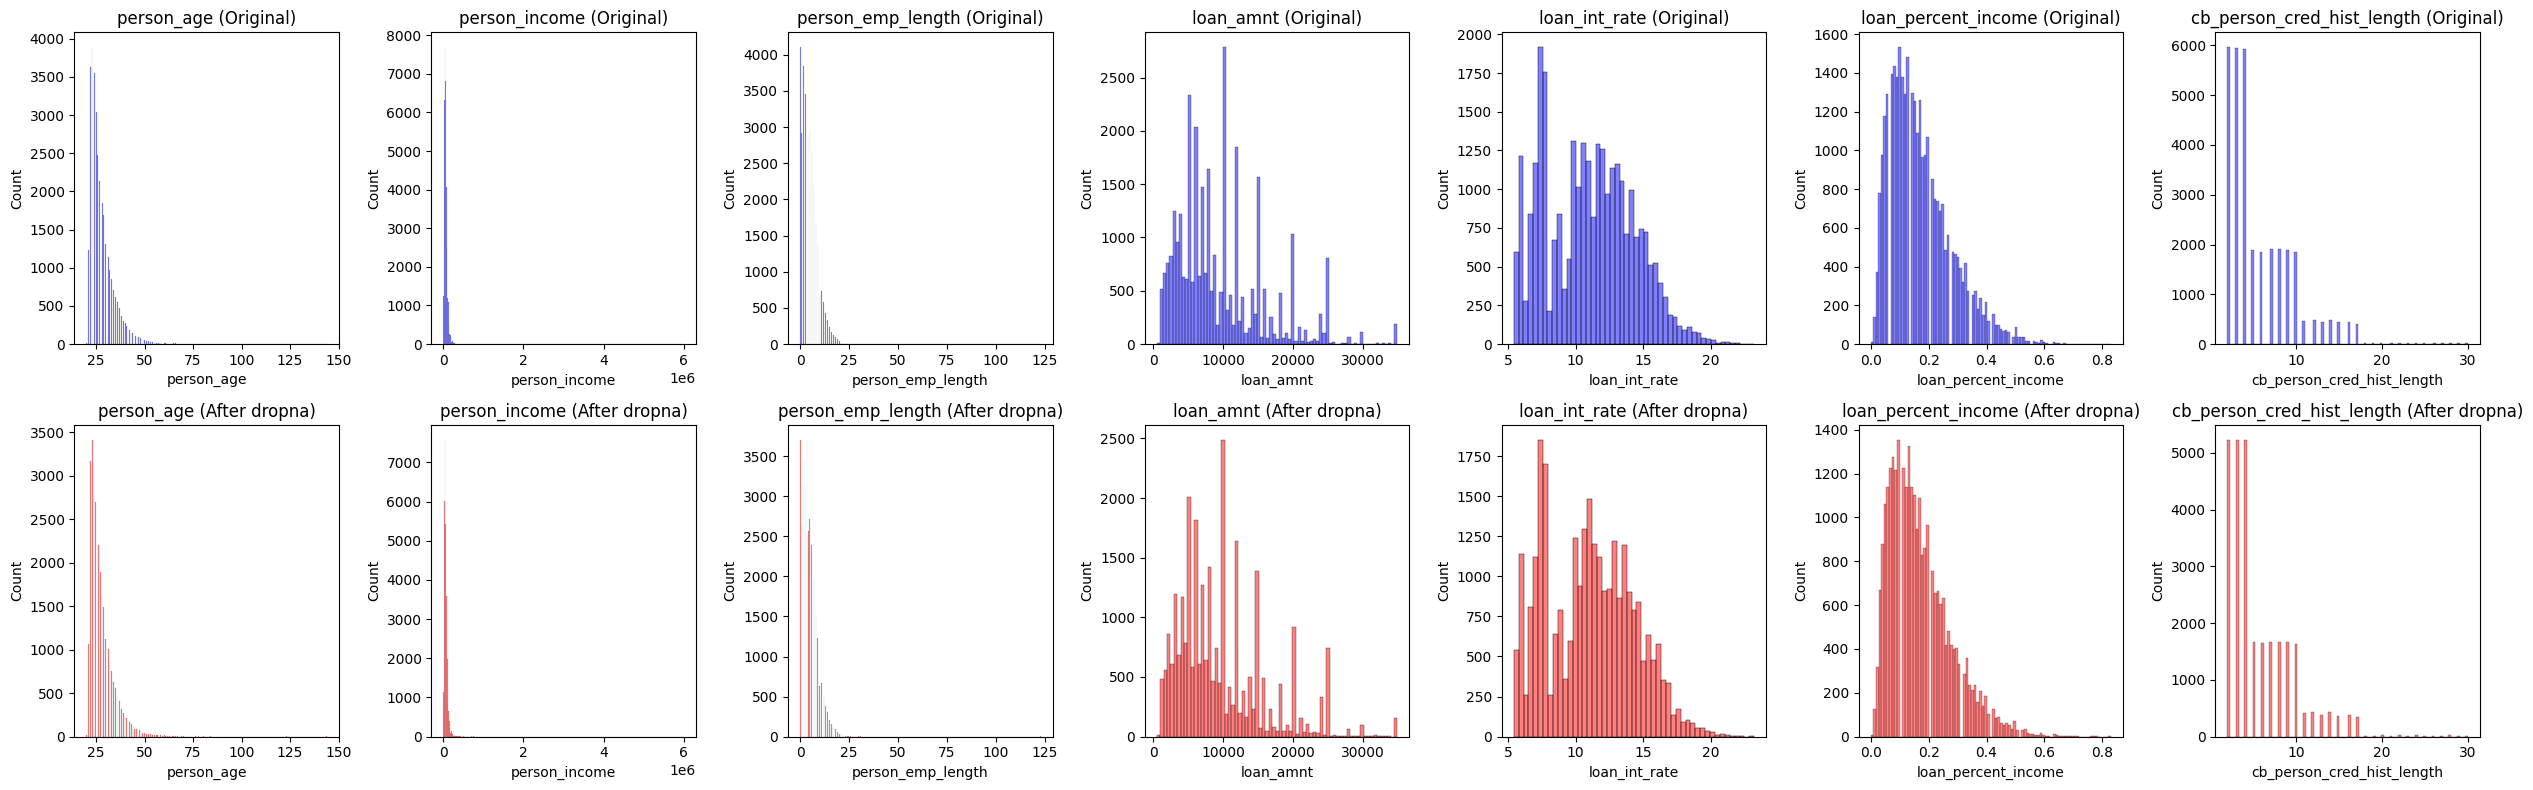

In [9]:
num_col = df.select_dtypes(include="number").columns

fig, axes = plt.subplots(2, 7, figsize=(25, 8))

for i, col in enumerate(num_col):
    sns.histplot(df[col], color='blue', alpha=0.5, ax=axes[0, i])
    axes[0, i].set_title(f'{col} (Original)')

for i, col in enumerate(num_col):
    sns.histplot(dropna_df[col], color='red', alpha=0.5, ax=axes[1, i])
    axes[1, i].set_title(f'{col} (After dropna)')

plt.tight_layout()
plt.show()

> distribution look kind of the same before and after dropping missing values.

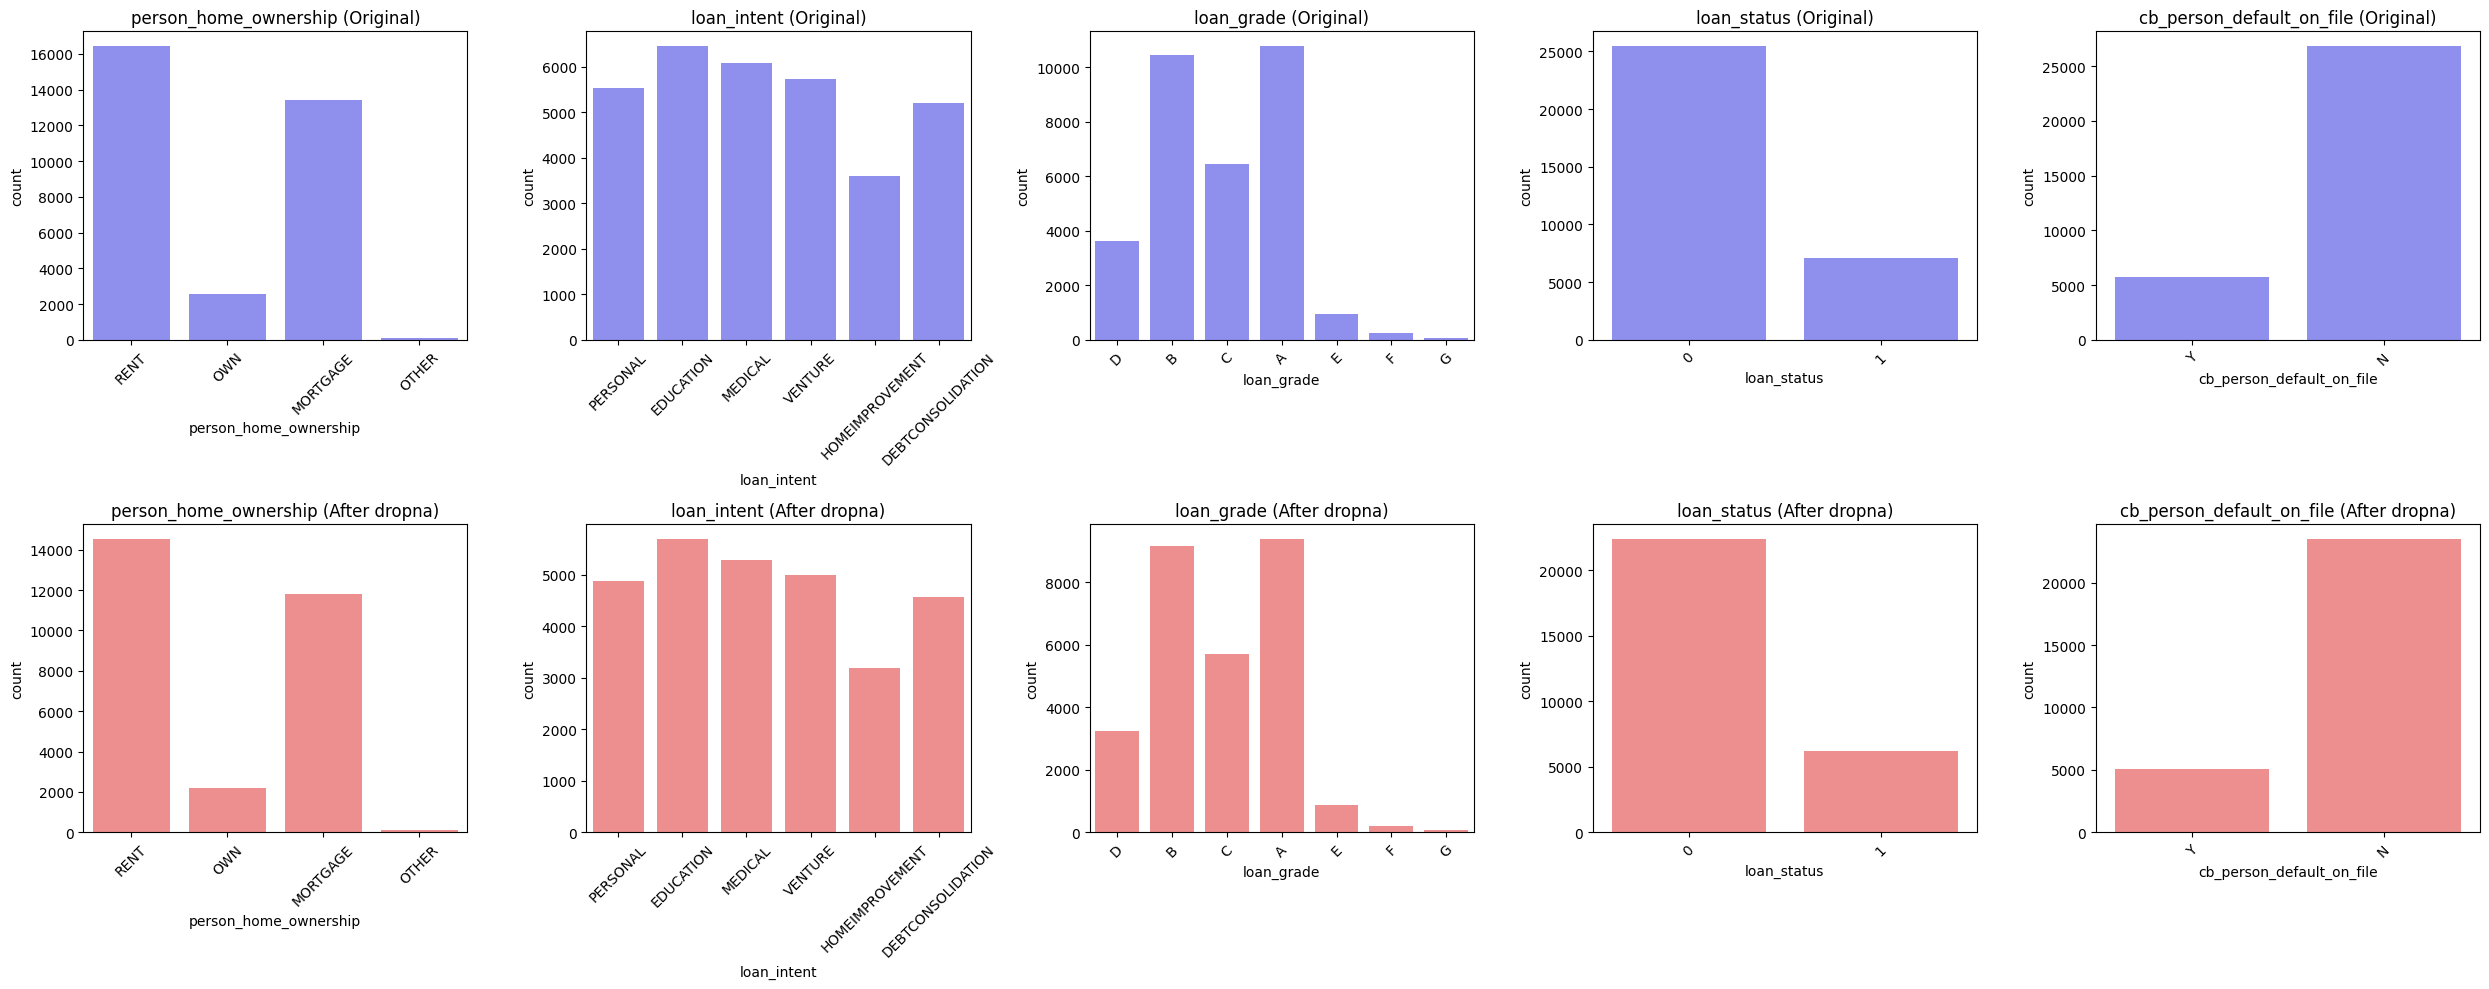

In [10]:
cat_col = df.select_dtypes(include="object")

fig, axes = plt.subplots(2, 5, figsize=(25, 10)) 

for i, col in enumerate(cat_col):
    sns.countplot(x=df[col], color='blue', alpha=0.5, ax=axes[0, i])
    axes[0, i].set_title(f'{col} (Original)')
    axes[0, i].tick_params(axis='x', rotation=45)

# Row 2: After dropping NA
for i, col in enumerate(cat_col):
    sns.countplot(x=dropna_df[col], color='red', alpha=0.5, ax=axes[1, i])
    axes[1, i].set_title(f'{col} (After dropna)')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

> nothing really change to categorical columns after dropping missing values.
> Decision: We can drop the missing values

In [11]:
df = df.dropna().reset_index(drop=True)
print(df.shape)

(28638, 12)


## Handling Outliers

In [12]:
for col in num_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: Found {len(outliers)} outliers = {(len(outliers)/len(df))*100:.2f}% of data")
    print("="*60)

person_age: Found 1298 outliers = 4.53% of data
person_income: Found 1329 outliers = 4.64% of data
person_emp_length: Found 773 outliers = 2.70% of data
loan_amnt: Found 1484 outliers = 5.18% of data
loan_int_rate: Found 6 outliers = 0.02% of data
loan_percent_income: Found 557 outliers = 1.94% of data
cb_person_cred_hist_length: Found 984 outliers = 3.44% of data


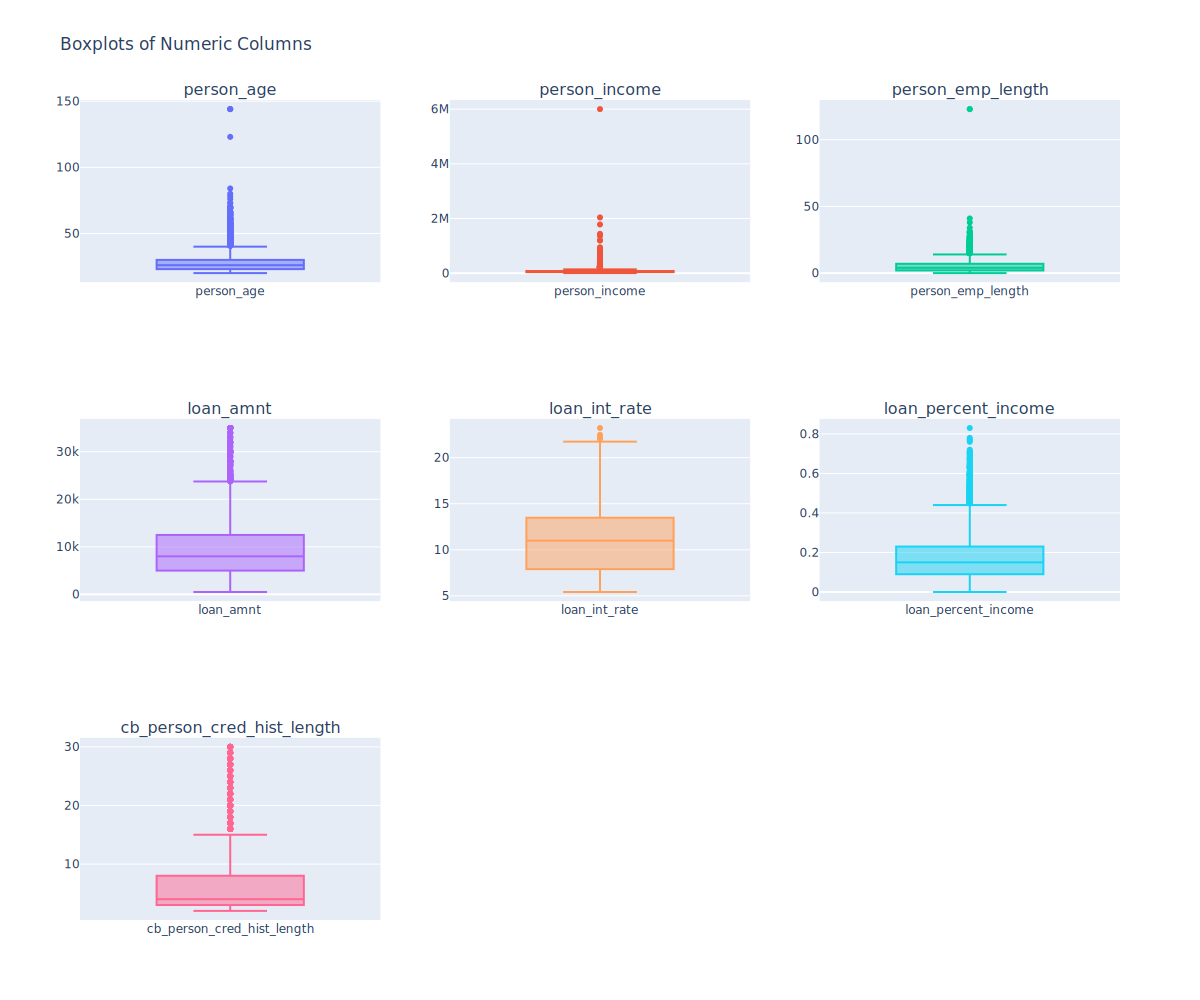

In [13]:
num_col = df.select_dtypes(include="number").columns

fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=num_col
)

for i, col_name in enumerate(num_col):
    row = i // 3 + 1
    col = i % 3 + 1
    fig.add_trace(
        go.Box(
            y=df[col_name],
            boxpoints='outliers',
            name=col_name,
            showlegend=False
        ),
        row=row, col=col
    )

fig.update_layout(
    height=1000, width=1200,
    title_text="Boxplots of Numeric Columns"
)

fig.show()

In [14]:
df.query('person_age > 100')

person_age  person_income person_home_ownership  person_emp_length  \
74            144         250000                  RENT                4.0   
163           144         200000              MORTGAGE                4.0   
508           123          80004                  RENT                2.0   
28388         144        6000000              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate loan_status  \
74        VENTURE          C       4800          13.57           0   
163     EDUCATION          B       6000          11.86           0   
508     EDUCATION          B      20400          10.25           0   
28388    PERSONAL          C       5000          12.73           0   

       loan_percent_income cb_person_default_on_file  \
74                    0.02                         N   
163                   0.03                         N   
508                   0.25                         N   
28388                 0.00                         N   

       cb_person_cred_hist_length  
74                              3  
163                             2  
508                             3  
28388                          25

In [15]:
print("age only 21-22 but employment length is 123 years")
df.query('person_emp_length > 40')

age only 21-22 but employment length is 123 years


person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
186            21         192000              MORTGAGE              123.0   
28440          78          48000                  RENT               41.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate loan_status  \
0        PERSONAL          D      35000          16.02           1   
186       VENTURE          A      20000           6.54           0   
28440     MEDICAL          A       3000           7.51           0   

       loan_percent_income cb_person_default_on_file  \
0                     0.59                         Y   
186                   0.10                         N   
28440                 0.06                         N   

       cb_person_cred_hist_length  
0                               3  
186                             4  
28440                          25

In [16]:
df = df.query('person_age <= 100 and person_emp_length <= 45')
df.shape

(28632, 12)

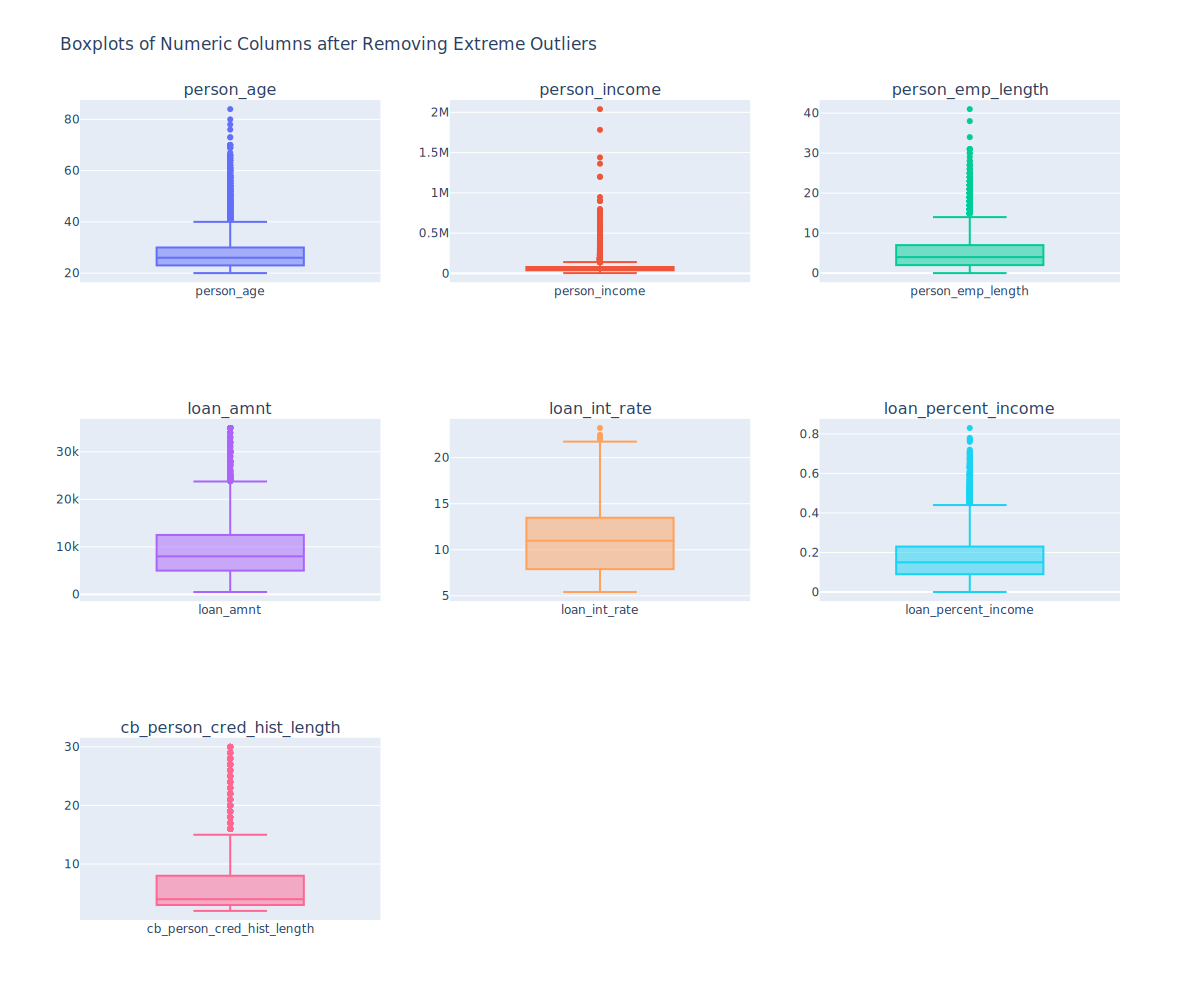

<Figure size 800x600 with 0 Axes>

In [17]:
plt.figure(figsize=(8, 6))
num_col = df.select_dtypes(include="number").columns
fig = make_subplots(rows=3, cols=3, subplot_titles=num_col)

for i, col in enumerate(num_col):
    row = i // 3 + 1
    col_idx = i % 3 + 1
    fig.add_trace(
        go.Box(y=df[col], boxpoints='outliers', name=col, showlegend=False),
        row=row, col=col_idx
    )

fig.update_layout(
    height=1000, width=1200,
    title_text="Boxplots of Numeric Columns after Removing Extreme Outliers"
)

fig.show()

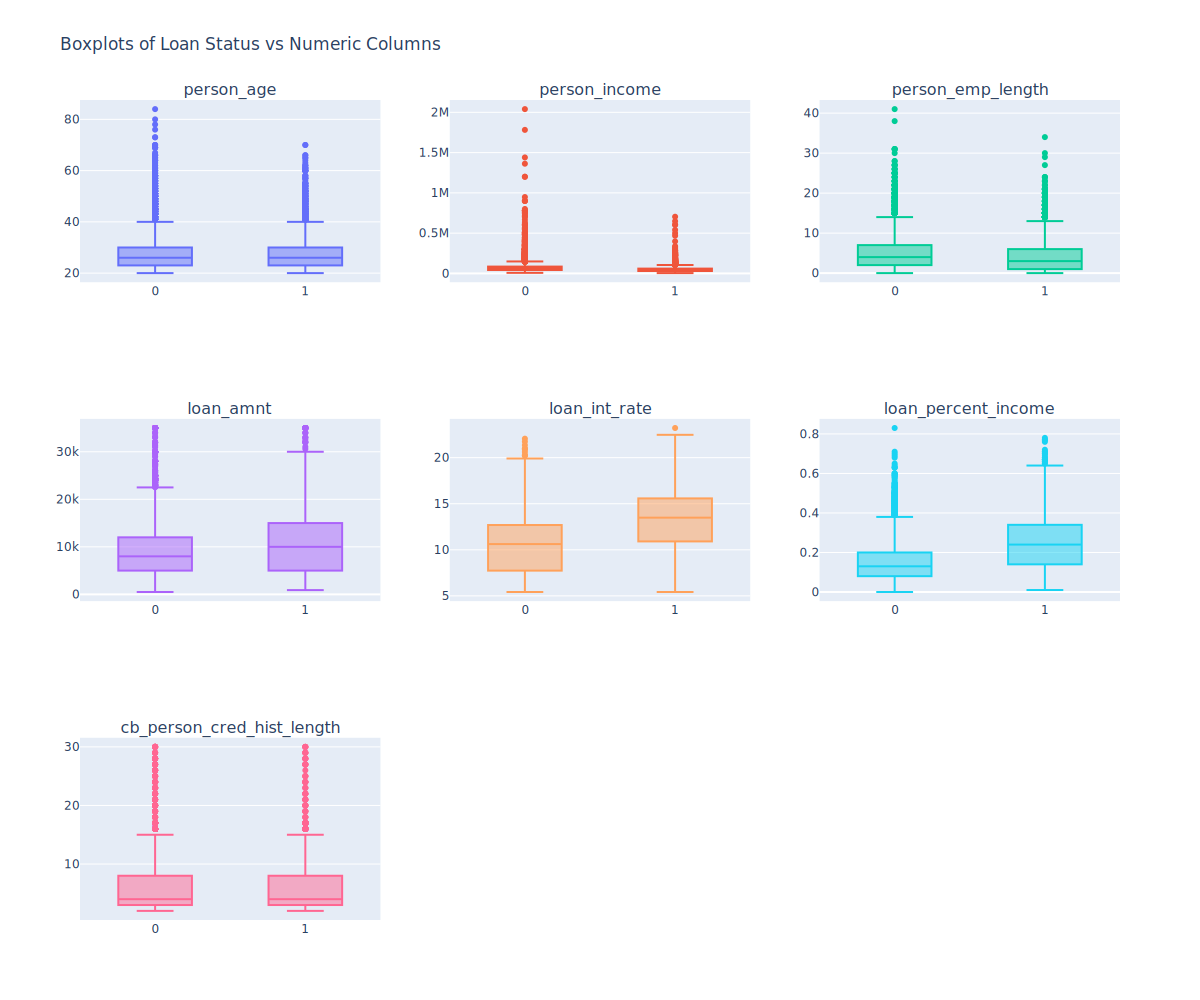

<Figure size 800x600 with 0 Axes>

In [18]:
plt.figure(figsize=(8, 6))
num_col = df.select_dtypes(include="number").columns
fig = make_subplots(rows=3, cols=3, subplot_titles=num_col)

for i, col in enumerate(num_col):
    row = i // 3 + 1
    col_idx = i % 3 + 1
    fig.add_trace(
        go.Box(x=df['loan_status'], y=df[col], boxpoints='outliers', name=col, showlegend=False),
        row=row, col=col_idx
    )

fig.update_layout(
    height=1000, width=1200,
    title_text="Boxplots of Loan Status vs Numeric Columns"
)

fig.show()

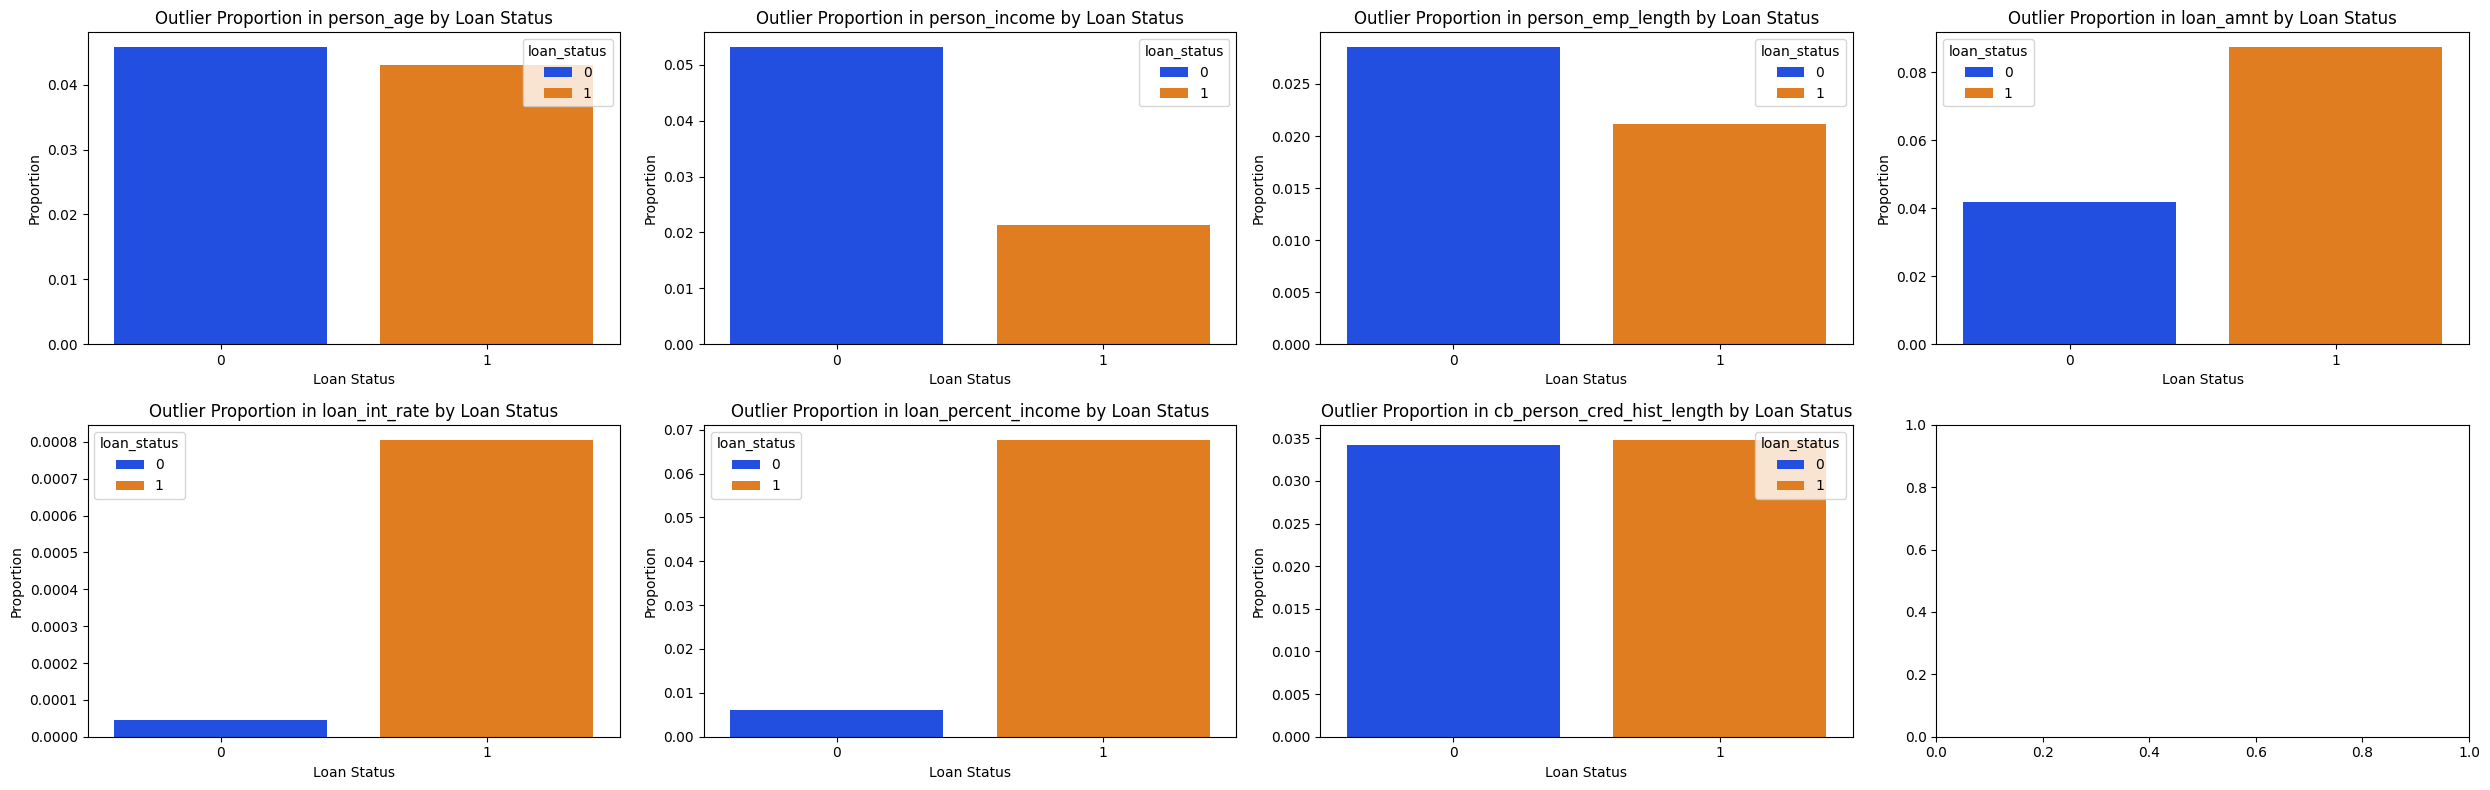

In [19]:
def get_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[series > Q3 + 1.5*IQR]

fig, axes = plt.subplots(2, 4, figsize=(25, 8))
axes = axes.flatten()

for i, col in enumerate(num_col):
    outliers = get_outliers(df[col])
    outlier_df = df.loc[outliers.index]
    
    # Compute normalized proportions
    counts = outlier_df['loan_status'].value_counts()
    prop = counts / df['loan_status'].value_counts()
    
    # Prepare data for plotting
    plot_df = prop.reset_index()
    plot_df.columns = ['loan_status', 'proportion']
    
    # Bar plot
    sns.barplot(x='loan_status', y='proportion', data=plot_df, palette='bright', hue="loan_status", ax=axes[i])
    axes[i].set_title(f'Outlier Proportion in {col} by Loan Status')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel('Loan Status')

plt.tight_layout()
plt.show()

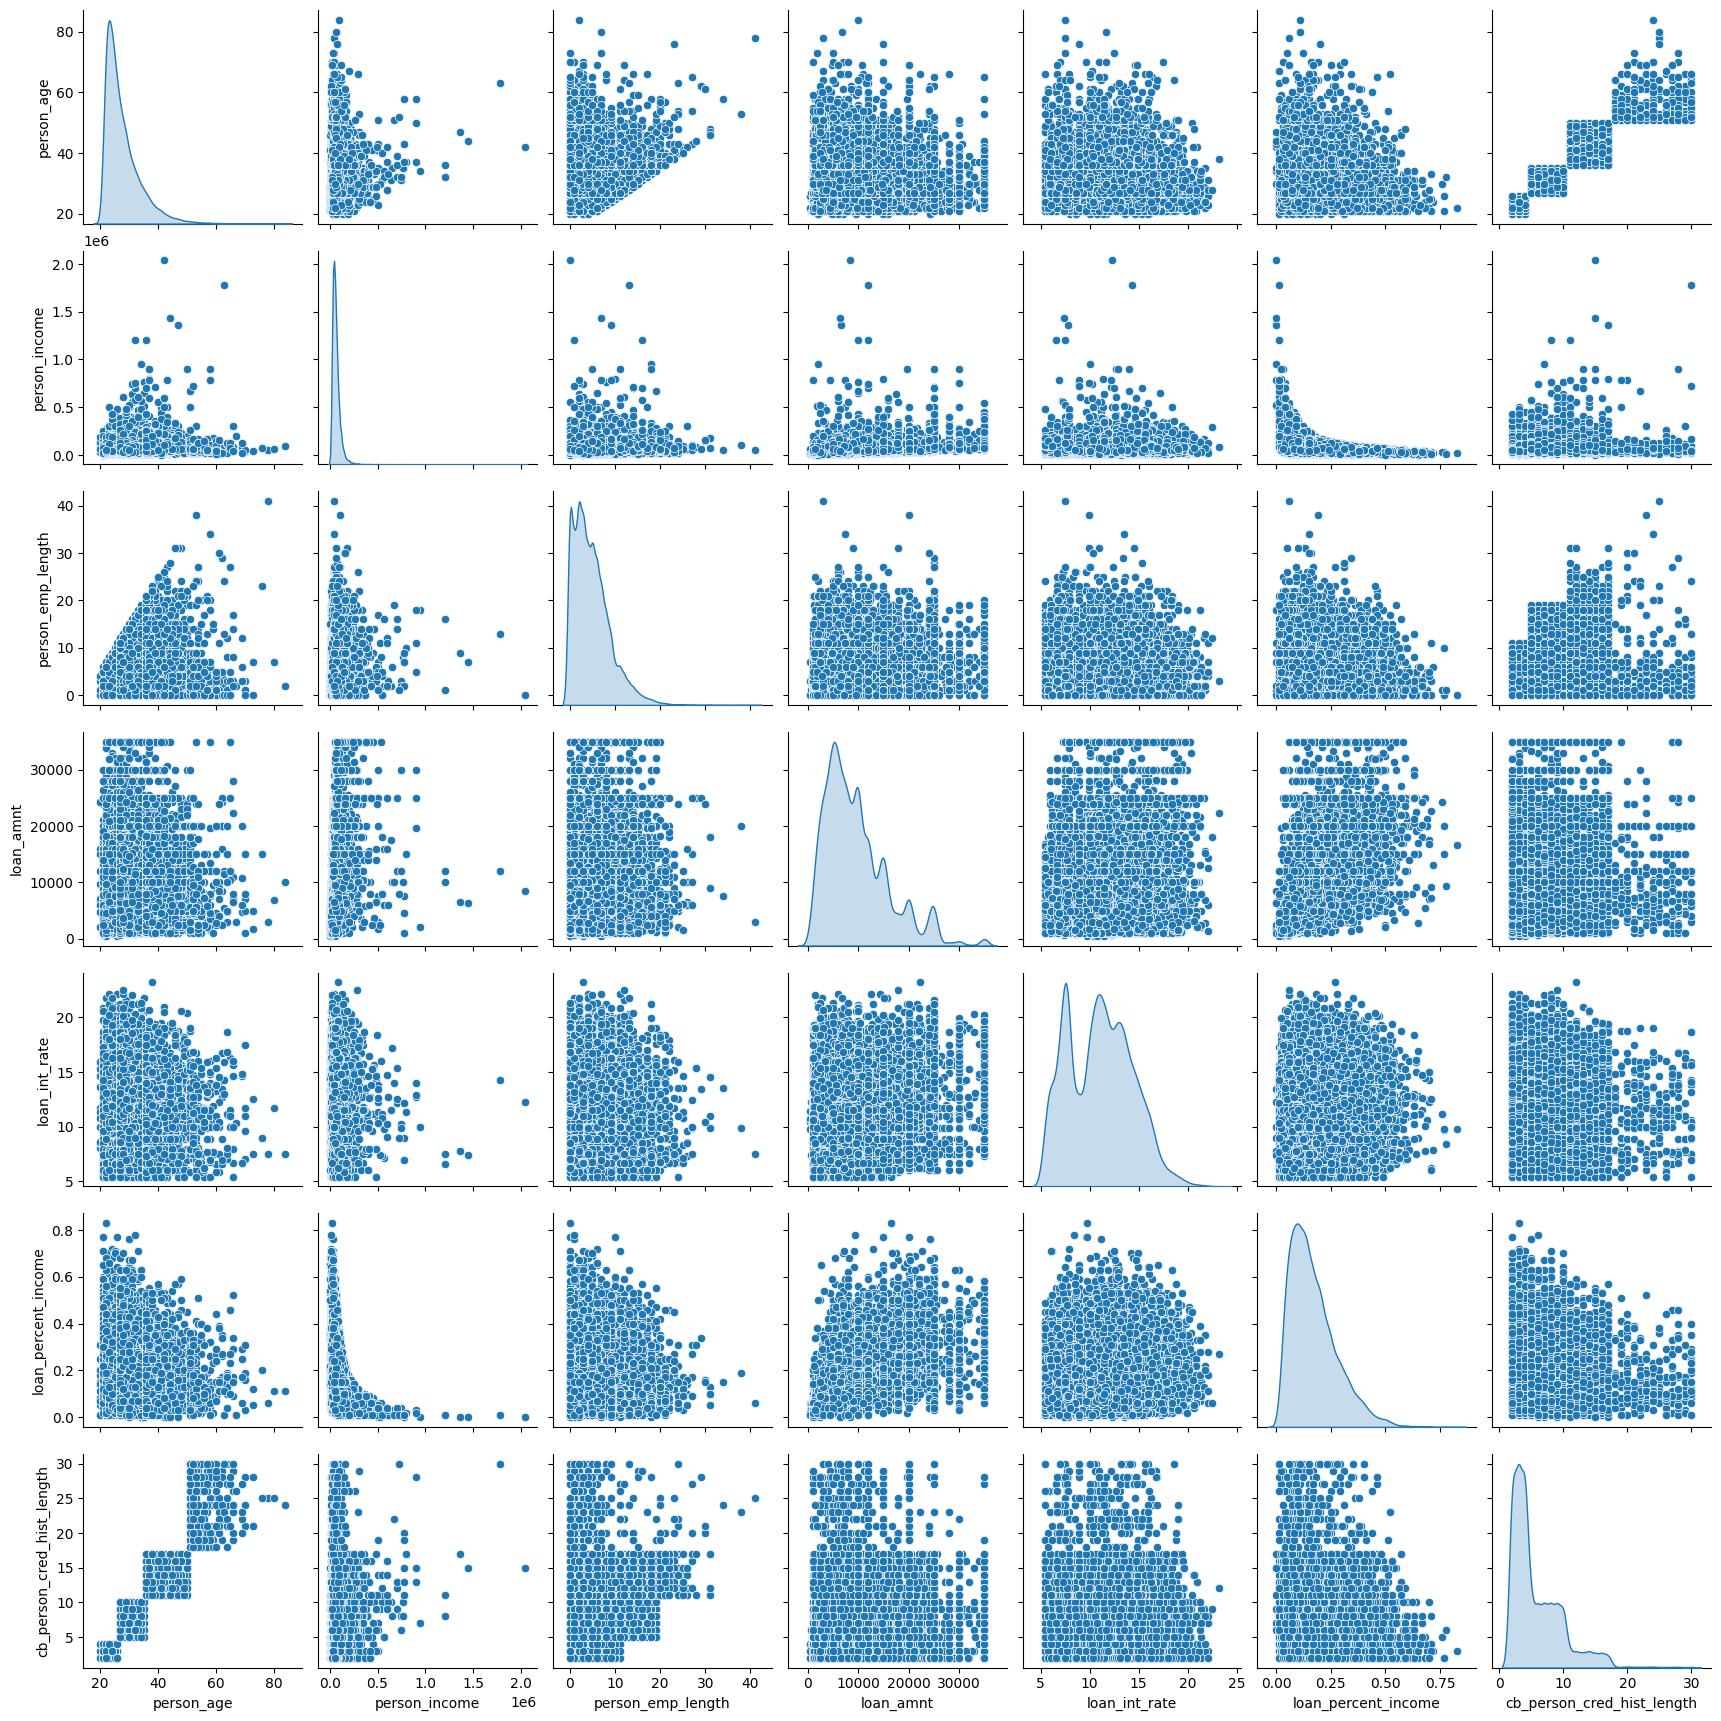

In [22]:
sns.pairplot(data=df.select_dtypes(include="number"), diag_kind='kde')
plt.show()

In [23]:
df.to_csv('../data/processed/credit_risk_dataset.csv', index=False)